In [1]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
import re
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight

In [13]:
# Load the dataset
dataset_url = 'KHS_dataset.txt'
data = pd.read_csv(dataset_url, sep=',')

# Extract labels
label_columns = ['contain_gender_bias', 'bias', 'hate']

def extract_labels(row):
    return [label_columns[i] for i in range(len(label_columns)) if row[i+1] == 1]

data['labels'] = data.apply(extract_labels, axis=1)

data['multi_class_label'] = data[label_columns].idxmax(axis=1)

In [14]:
y_df = pd.DataFrame(data, columns=label_columns)

# Calculate the distribution of each combination
combination_distribution = y_df.groupby(label_columns).size().reset_index(name='count')

# Print the distribution
print(combination_distribution)

   contain_gender_bias  bias  hate  count
0                    0     0     0   3273
1                    0     0     1   1875
2                    0     1     0    137
3                    0     1     1   1379
4                    1     1     0     76
5                    1     1     1   1156


In [15]:
from nltk.corpus import wordnet
import random
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

# Separate each label into separate columns
for label in label_columns:
    data[label] = data['labels'].apply(lambda x: 1 if label in x else 0)

# Check insufficient class
combination_distribution = data.groupby(label_columns).size().reset_index(name='count')
print("Class combination distribution before augmentation:")
print(combination_distribution)

# Set criteria for class combinations to augment
augmentation_threshold = 1000
combinations_to_augment = combination_distribution[combination_distribution['count'] < augmentation_threshold]

# Augmentation Define
def synonym_replacement(sentence, n):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stopwords.words('english')]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    if word in synonyms:
        synonyms.remove(word)
    return synonyms

def random_insertion(sentence, n):
    words = sentence.split()
    for _ in range(n):
        new_word = random.choice(words)
        synonyms = get_synonyms(new_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            insert_pos = random.randint(0, len(words)-1)
            words.insert(insert_pos, synonym)
    return ' '.join(words)

def random_deletion(sentence, p):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    if len(new_words) == 0:
        return random.choice(words)
    return ' '.join(new_words)

def random_swap(sentence, n):
    words = sentence.split()
    length = len(words)
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

# Data augmentation function
def augment_data(row, n_synonym_replacements=2, n_random_insertions=2, n_random_deletions=2, n_random_swaps=2):
    augmented_sentences = []

    # synonym_replacement
    augmented_sentences.append(synonym_replacement(row['comments'], n_synonym_replacements))

    # random_insertion
    augmented_sentences.append(random_insertion(row['comments'], n_random_insertions))

    # random_deletion
    augmented_sentences.append(random_deletion(row['comments'], 0.2))  # 20% 확률로 단어 삭제

    # random_swap
    augmented_sentences.append(random_swap(row['comments'], n_random_swaps))

    augmented_data = [{'comments': sentence, 'contain_gender_bias': row['contain_gender_bias'], 'bias': row['bias'], 'hate': row['hate']} for sentence in augmented_sentences]
    return augmented_data

# Augmented only data from insufficient class combinations
augmented_data = []

for index, row in combinations_to_augment.iterrows():
    condition = (data['contain_gender_bias'] == row['contain_gender_bias']) & (data['bias'] == row['bias']) & (data['hate'] == row['hate'])
    class_data = data[condition]
    for idx, class_row in class_data.iterrows():
        augmented_data.extend(augment_data(class_row))

# Create augmented data frames
augmented_df = pd.DataFrame(augmented_data)

# concate original and augmented data
final_data = pd.concat([data, augmented_df])

y_augmented = final_data[['contain_gender_bias', 'bias', 'hate']].values

print(f'Shape of augmented y: {y_augmented.shape}')

# class distribution after augmentation
y_df_augmented = pd.DataFrame(y_augmented, columns=label_columns)
combination_distribution_augmented = y_df_augmented.groupby(label_columns).size().reset_index(name='count')
print("Class combination distribution after augmentation:")
print(combination_distribution_augmented)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Class combination distribution before augmentation:
   contain_gender_bias  bias  hate  count
0                    0     0     0   3273
1                    0     0     1   1875
2                    0     1     0    137
3                    0     1     1   1379
4                    1     1     0     76
5                    1     1     1   1156
Shape of augmented y: (8748, 3)
Class combination distribution after augmentation:
   contain_gender_bias  bias  hate  count
0                    0     0     0   3273
1                    0     0     1   1875
2                    0     1     0    685
3                    0     1     1   1379
4                    1     1     0    380
5                    1     1     1   1156


In [16]:
final_data['multi_class_label'] = final_data[label_columns].idxmax(axis=1)

# Encode Label & Make label column
id2label = {k:v for k, v in enumerate(final_data['multi_class_label'].unique())}
label2id = {v:k for k, v in id2label.items()}

final_data['labels'] = final_data['multi_class_label'].map(label2id)

# Split and Make Dataset
train_data, temp_data = train_test_split(final_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)


In [17]:
# Tokenize Dataset
tokenizer = AutoTokenizer.from_pretrained('monologg/koelectra-base-v3-discriminator')

def tokenize_data(data):
    encoded = tokenizer(
        data['comments'],
        truncation=True
    )
    encoded['labels'] = data['labels']
    return encoded

tokenized_train_dataset = train_dataset.map(tokenize_data, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_data, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_data, batched=True)

# Load Collator
collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest'    # pad to longest sequence in batch
)

Map:   0%|          | 0/6998 [00:00<?, ? examples/s]

Map:   0%|          | 0/875 [00:00<?, ? examples/s]

Map:   0%|          | 0/875 [00:00<?, ? examples/s]

In [18]:
from transformers import TrainingArguments
# Adjust training arguments
training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=10,
        weight_decay=.01,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=3e-5,
        evaluation_strategy='steps',
        eval_steps=300,
        save_strategy='steps',
        save_steps=300,
        logging_strategy='steps',
        logging_steps=500,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
        greater_is_better=True,
        lr_scheduler_type='cosine',
        warmup_ratio=0.1
    )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
# Define metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average='weighted')
    precision = precision_score(p.label_ids, preds, average='weighted')
    return {'accuracy': accuracy, 'f1': f1, 'precision': round(precision, 6)}

# Load model
model = AutoModelForSequenceClassification.from_pretrained('monologg/koelectra-base-v3-discriminator', num_labels=len(label2id))

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=collator,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision
300,No log,0.958660,0.541714,0.380686,0.293454
600,0.960800,0.782129,0.648000,0.609672,0.607358
900,0.960800,0.752442,0.683429,0.684382,0.685567
1200,0.684700,0.929947,0.683429,0.670146,0.692717
1500,0.406700,0.947174,0.702857,0.699557,0.697918
1800,0.406700,1.202390,0.680000,0.665137,0.673420
2100,0.235100,1.283895,0.676571,0.681591,0.690180
2400,0.235100,1.755687,0.688000,0.680483,0.697180
2700,0.112000,1.765105,0.700571,0.702167,0.723956
3000,0.065200,1.953787,0.688000,0.681356,0.696592


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=4380, training_loss=0.29013958695816666, metrics={'train_runtime': 1383.9127, 'train_samples_per_second': 50.567, 'train_steps_per_second': 3.165, 'total_flos': 2130188841235224.0, 'train_loss': 0.29013958695816666, 'epoch': 10.0})

In [25]:
# Evaluate
test_results = trainer.evaluate(tokenized_test_dataset)
print(f"Test Accuracy: {test_results['eval_accuracy']}")
print(f"Test F1 Score: {test_results['eval_f1']}")
print(f"Test Precision: {test_results['eval_precision']}")

Test Accuracy: 0.7051428571428572
Test F1 Score: 0.7098211093870057
Test Precision: 0.728031


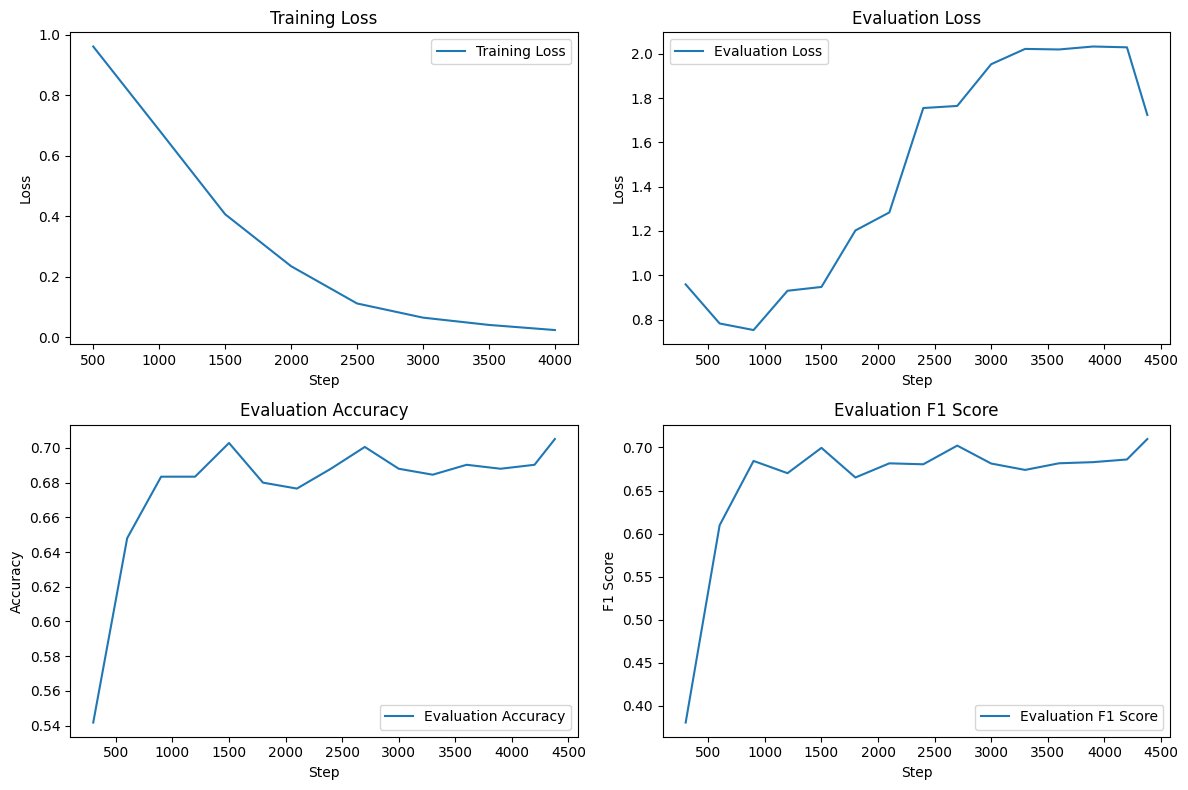

In [26]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Creating the plots
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(eval_steps, eval_accuracy, label='Evaluation Accuracy')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(eval_steps, eval_f1, label='Evaluation F1 Score')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('F1 Score')
plt.title('Evaluation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

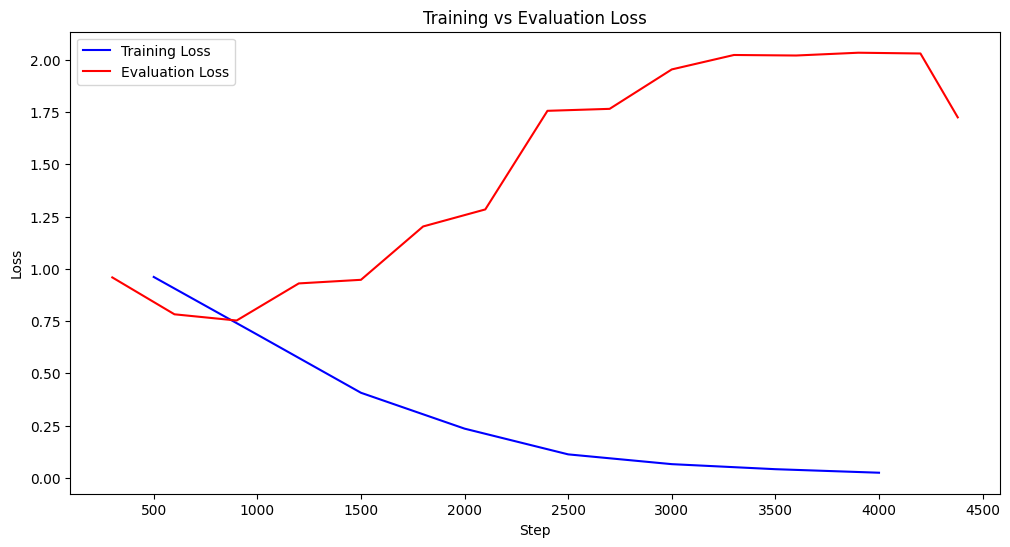

In [27]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Plotting Loss (Training and Evaluation on the same graph)
plt.figure(figsize=(12, 6))

plt.plot(train_steps, train_loss, label='Training Loss', color='blue')
plt.plot(eval_steps, eval_loss, label='Evaluation Loss', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()

In [28]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=d142d53427957215ab24bb0a6ead95fa79af0c88ab076be2859e9a93661caad9
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [29]:
from lime.lime_text import LimeTextExplainer
import numpy as np
import matplotlib.font_manager as fm
import torch
import re

abusive_indices = test_data[test_data['multi_class_label'] == 'hate'].index.tolist()

# '악플/욕설' 라벨이 있는 데이터 10개 출력
for idx in abusive_indices[:10]:
    text_str = test_data.loc[idx, 'comments']  # '문장' 열에 텍스트가 저장되어 있습니다.
    label = test_data.loc[idx, 'multi_class_label']  # 'multi_class_label' 열에서 라벨을 가져옵니다.
    print(f"Index: {idx}, Text: {text_str}, Label: {label}")

Index: 3027, Text: 별게 다 논란이네 ㅋㅋㅋㅋ 그래서 가해자는 잡았냐??, Label: hate
Index: 4354, Text: 양준일이 뭐 잘나가고 그런건 상관없는데...그렇다고 표절곡을 대놓고 방송해주는건 아니잖아..., Label: hate
Index: 1144, Text: 김건모 가 부릅니다. 도자기 처럼 깨진 사랑., Label: hate
Index: 411, Text: 개돼지 네티즌은 무었이 진실인지는 중요하지 않고 니편 내편이 중요한거지. 음식에 이념을 갖다 붙이고 비판하는 넘들 진짜 한심한 부류들..., Label: hate
Index: 3396, Text: 서진이는 효리 승기는 윤아 서준이는 누구랑 만났냐, Label: hate
Index: 7201, Text: 출연료들을 너무 많이 주니까 저런일이 벌어지는 것이다.개는 똥을 못끊는다...., Label: hate
Index: 2697, Text: 뭘 또 그렇게 비난이 쏟아져... 사람들 별로 관심도 없던데 기자들만 난리네., Label: hate
Index: 3884, Text: 쌌구나 쌌어~~, Label: hate
Index: 6044, Text: 이프로를 왜하는지..뭘보여주고싶은지...그정도 카페로 도대체 일하는사람이 몇명인지..현실에선 상상하기 힘든일!!진짜로 삶의 터전인 사람에게 실례가 되지않은지..., Label: hate
Index: 1758, Text: 누가 보면 독립운동 하러 가는 줄 알겠네. 하하가 먹던 사회에서의 마지막 햄버거냐?, Label: hate


In [30]:
# 모델을 GPU로 이동
model = model.to('cuda')

# predict_proba 함수 수정
def predict_proba(texts):
    # 텍스트를 리스트로 받아 한 번에 처리
    encoded_texts = tokenizer(texts, truncation=True, padding=True, return_tensors='pt', max_length=512)
    encoded_texts = {k: v.to('cuda') for k, v in encoded_texts.items()}
    with torch.no_grad():
        outputs = model(**encoded_texts)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return predictions.to('cpu').numpy()

# LIME 설명 생성기를 멀티 클래스 라벨에 맞게 초기화
class_names = ['contain_gender_bias', 'bias', 'hate']
explainer = LimeTextExplainer(class_names=class_names)

# 샘플 텍스트 선택
idx = 0
sample_text = test_data.iloc[idx]['comments']  # '문장' 열을 사용

# LIME 설명 생성
exp = explainer.explain_instance(sample_text, predict_proba, num_features=6, labels=range(len(class_names)))
print(exp.as_list())

[('남녀를', 0.2548203774755825), ('떠나', -0.11255066710829333), ('불법이아닌데', 0.0976055939192874), ('즐기고살기', 0.08289878926229129), ('애낳아', 0.06030232704291039), ('성관계해도', 0.05624943181984213)]


In [47]:
random_indices = np.random.choice(test_data.index, size=5, replace=False)
for idx in random_indices:
    sample_text = test_data.loc[idx]['comments']
    # LIME을 사용하여 예측 설명 생성
    exp = explainer.explain_instance(sample_text, predict_proba, num_features=6,labels=range(len(class_names)))

    # 설명 출력 (텍스트로 출력)
    print(f"Explanation for index {idx}:")
    print(exp.as_list())

Explanation for index 5965:
[('이자식', -0.3013479968948778), ('딸이있네', -0.2673294484646861), ('어디', -0.08744395163212941), ('숨겨놓은', -0.07666495826218604), ('게이라더니', -0.013504862379892959)]
Explanation for index 2138:
[('되게', 0.0005303925782474439), ('괜찮은', 0.0005126282300696262), ('배우네', 0.00035773139623255487)]
Explanation for index 298:
[('군대안가는', -0.21402033902467751), ('미국인은', -0.209656792746092), ('아니겠죠', -0.11691914686023591), ('애들은', -0.11169417340361246)]
Explanation for index 2304:
[('똑똑하고', 0.3731035434494397), ('알베르토', 0.3616374888852134), ('겸손한', 0.17034315758569502)]
Explanation for index 2215:
[('입대하자', -0.538848828372424), ('망했으니', -0.1663832099976276), ('이제', 0.1464724133025481), ('드라마', 0.11302668663815747), ('ㅠㅠ', -0.014091329349623507)]


In [48]:
# Save the explanation to an HTML file
exp.save_to_file('lime_explanation.html')